## Mortality Rate

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

le = LabelEncoder()
pca=PCA()
sc=StandardScaler()

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

import random
import os
import time

df_train = pd.read_excel('training_data.xlsx')
df_test = pd.read_excel('test_data.xlsx')

### Exploratory Data Analysis

In [2]:
df_train.dtypes

ID               int64
Severity        object
Ventilation     object
Mean Age       float64
% Male         float64
                ...   
Unnamed: 86    float64
Unnamed: 87    float64
Unnamed: 88    float64
Unnamed: 89    float64
Unnamed: 90    float64
Length: 91, dtype: object

In [3]:
df_train.head()

,ID,Severity,Ventilation,Mean Age,% Male,Any Comorbidity,Hypertension,Diabetes,Cardiovascular Disease (incl. CAD),Chronic obstructive lung (COPD),...,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90
0,1,All,Both,NaN,0.6230,0.4760,0.3000,0.1900,0.0800,0.0300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Severe/Critical Only,Both,NaN,0.7037,0.6667,0.4815,0.3148,0.2407,0.0741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,All,Both,NaN,0.5912,0.4015,0.2336,0.1387,0.0146,0.0146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,All,Both,NaN,0.6030,NaN,NaN,0.1160,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,All,Both,NaN,0.6160,NaN,NaN,0.1010,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_train.shape

(475, 91)

In [5]:
df_train.columns

Index(['ID', 'Severity', 'Ventilation', 'Mean Age', '% Male',
       'Any Comorbidity', 'Hypertension', 'Diabetes',
       'Cardiovascular Disease (incl. CAD)', 'Chronic obstructive lung (COPD)',
       'Cancer (Any)', 'Liver Disease (any)', 'Cerebrovascular Disease',
       'Chronic kidney/renal disease', 'Other', 'Fever (temperature ≥37·3°C)',
       'Average temperature (celsius)', 'Max temperature (celsius)',
       'Respiratory rate > 24 breaths per min', 'Cough',
       'Shortness of Breath (dyspnoea)', 'Headache', 'Sputum (/Expectoration)',
       'Myalgia (Muscle Pain)', 'Fatigue', 'Diarrhoea', 'Nausea or Vomiting',
       'Loss of Appetite/Anorexia', 'Disease Severity Asymptomatic',
       'Disease Severity General', 'Disease Severity Severe',
       'Disease Severity Critical', 'White Blood Cell Count (10^9/L) - Median',
       'White Blood Cell Count (10^9/L) - LQ',
       'White Blood Cell Count (10^9/L) - UQ',
       'Lymphocyte Count (10^9/L) - Median', 'Lymphocyte Count 

In [6]:
# Most of the rows are irrelvent so dropping the below columns

df_train.drop(['Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58',
       'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62',
       'Unnamed: 63', 'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66',
       'Unnamed: 67', 'Unnamed: 68', 'Unnamed: 69', 'Unnamed: 70',
       'Unnamed: 71', 'Unnamed: 72', 'Unnamed: 73', 'Unnamed: 74',
       'Unnamed: 75', 'Unnamed: 76', 'Unnamed: 77', 'Unnamed: 78',
       'Unnamed: 79', 'Unnamed: 80', 'Unnamed: 81', 'Unnamed: 82',
       'Unnamed: 83', 'Unnamed: 84', 'Unnamed: 85', 'Unnamed: 86',
       'Unnamed: 87', 'Unnamed: 88', 'Unnamed: 89', 'Unnamed: 90'],axis=1,inplace=True)

In [7]:
# Replacing the relevent meaningful data and forward filling the missing values, since the missing value is less in these columns

df_train['Ventilation'].replace({'Ventilation only':'Yes','Non-ventilation only':'No'},inplace=True)
df_train['Ventilation'].ffill(inplace=True)

df_train['Severity'].replace({'Severe/Critical Only':'Severe', 'Severe/critical only':'Severe','Both':'All',
                              'Mild only':'Mild','Asymptomatic only':'Mild'},inplace=True)
df_train['Severity'].ffill(inplace=True)

In [8]:
# Guessing that, NaN means that patient might not be moved to ICU, so making those as 0
df_train['ICU length of stay, days'].fillna(0,inplace=True)
df_train['ICU length of stay, days'].replace({'na':0},inplace=True)

In [9]:
# Basic corona hospital quarantine used to be 15 days so updated as it is. And NA as 0
df_train['Hospital length of stay, days'].fillna(15,inplace=True)
df_train['Hospital length of stay, days'].replace({'na':0},inplace=True)

In [10]:
# Updated below columns as 0, since those disease are complecated, so considered the NaN as 0

fillna_zeros = ['Any Comorbidity','Hypertension', 'Diabetes','Cardiovascular Disease (incl. CAD)', 'Chronic obstructive lung (COPD)','Cancer (Any)',
         'Liver Disease (any)', 'Cerebrovascular Disease','Chronic kidney/renal disease', 'Other','Antibiotic', 'Antiviral (Any)',
         'Heart failure','Acute kidney injury (AKI)', 'Secondary infection/ Bacterial infection']

df_train[fillna_zeros] = df_train[fillna_zeros].fillna(0)

In [11]:
# Updating the below columns with mean value. 
# These are some of the symptoms of corona, so mean value works best to fill the NaN in it

mean_cols_train = ['Fever (temperature ≥37·3°C)',
       'Average temperature (celsius)', 'Max temperature (celsius)',
       'Respiratory rate > 24 breaths per min', 'Cough',
       'Shortness of Breath (dyspnoea)', 'Headache', 'Sputum (/Expectoration)',
       'Myalgia (Muscle Pain)', 'Fatigue', 'Diarrhoea', 'Nausea or Vomiting',
       'Loss of Appetite/Anorexia', 'Disease Severity Asymptomatic',
       'Disease Severity General', 'Disease Severity Severe',
       'Disease Severity Critical', 'White Blood Cell Count (10^9/L) - Median',
       'White Blood Cell Count (10^9/L) - LQ',
       'White Blood Cell Count (10^9/L) - UQ',
       'Lymphocyte Count (10^9/L) - Median', 'Lymphocyte Count (10^9/L) - LQ',
       'Lymphocyte Count (10^9/L) - UQ', 'Platelet Count (10^9/L) - Median',
       'Platelet Count (10^9/L) - LQ', 'Platelet Count (10^9/L) - UQ',
       'Hemoglobin (g/L) - Median', 'Hemoglobin (g/L) - LQ',
       'Hemoglobin (g/L) - UQ', 'Albumin (g/L)',
       'Alanine Aminotransferase (U/L)', 'Aspartate Aminotransferase (U/L)', '% Male','Mean Age']

df_train[mean_cols_train] = df_train[mean_cols_train].fillna(df_train[mean_cols_train].median())

In [12]:
# Considering that, NA or 0% as the patient doesn't have corona or cured. So updated as 0
df_train['Mortality'].replace({'na':0,'0%%':0},inplace=True)

In [13]:
# Label encoding the below column
df_train['Severity']=le.fit_transform(df_train['Severity'])
df_train['Ventilation']=le.fit_transform(df_train['Ventilation'])

In [14]:
# Normalizing the below columns using min ma scale technique, since those columns are having higher values comparing to others
mms_cols = ['Mean Age', 'Average temperature (celsius)', 'Max temperature (celsius)',
            'Platelet Count (10^9/L) - Median', 'Platelet Count (10^9/L) - LQ', 'Platelet Count (10^9/L) - UQ', 
            'Hemoglobin (g/L) - Median', 'Hemoglobin (g/L) - LQ', 'Hemoglobin (g/L) - UQ', 'Albumin (g/L)', 
            'Alanine Aminotransferase (U/L)', 'Aspartate Aminotransferase (U/L)']
mms=MinMaxScaler()
df_train[mms_cols] = mms.fit_transform(df_train[mms_cols])

In [15]:
# Checking the dataset before injucting the model

print(df_train.dtypes)
print('\n\n')
print(df_train.isnull().sum())

ID                                            int64
Severity                                      int32
Ventilation                                   int32
Mean Age                                    float64
% Male                                      float64
Any Comorbidity                             float64
Hypertension                                float64
Diabetes                                    float64
Cardiovascular Disease (incl. CAD)          float64
Chronic obstructive lung (COPD)             float64
Cancer (Any)                                float64
Liver Disease (any)                         float64
Cerebrovascular Disease                     float64
Chronic kidney/renal disease                float64
Other                                       float64
Fever (temperature ≥37·3°C)                 float64
Average temperature (celsius)               float64
Max temperature (celsius)                   float64
Respiratory rate > 24 breaths per min       float64
Cough       

#### Applying the same above techniques below

In [16]:
df_valid=df_test

In [17]:
df_valid['Ventilation'].replace({'Ventilation only':'Yes','Non-ventilation only':'No'},inplace=True)
df_valid['Ventilation'].ffill(inplace=True)

df_valid['Severity'].replace({'Severe/Critical Only':'Severe', 'Severe/critical only':'Severe','Both':'All',
                              'Mild only':'Mild','Asymptomatic only':'Mild'},inplace=True)
df_valid['Severity'].ffill(inplace=True)

df_valid['ICU length of stay, days'].fillna(0,inplace=True)
#df_valid['ICU length of stay, days'].replace({'na':0},inplace=True)

df_valid['Hospital length of stay, days'].fillna(15,inplace=True)
#df_valid['Hospital length of stay, days'].replace({'na':0},inplace=True)

fillna_zeros = ['Any Comorbidity','Hypertension', 'Diabetes','Cardiovascular Disease (incl. CAD)', 'Chronic obstructive lung (COPD)','Cancer (Any)',
         'Liver Disease (any)', 'Cerebrovascular Disease','Chronic kidney/renal disease', 'Other','Antibiotic', 'Antiviral (Any)',
         'Heart failure','Acute kidney injury (AKI)', 'Secondary infection/ Bacterial infection']

df_valid[fillna_zeros] = df_valid[fillna_zeros].fillna(0)

df_valid['Albumin (g/L)'].fillna(33,inplace=True)


mean_cols1 = ['Fever (temperature ≥37·3°C)',
       'Average temperature (celsius)', 'Max temperature (celsius)',
       'Respiratory rate > 24 breaths per min', 'Cough',
       'Shortness of Breath (dyspnoea)', 'Headache', 'Sputum (/Expectoration)',
       'Myalgia (Muscle Pain)', 'Fatigue', 'Diarrhoea', 'Nausea or Vomiting',
       'Loss of Appetite/Anorexia', 'Disease Severity Asymptomatic',
       'Disease Severity General', 'Disease Severity Severe',
       'Disease Severity Critical', 'White Blood Cell Count (10^9/L) - Median',
       'White Blood Cell Count (10^9/L) - LQ',
       'White Blood Cell Count (10^9/L) - UQ',
       'Lymphocyte Count (10^9/L) - Median', 'Lymphocyte Count (10^9/L) - LQ',
       'Lymphocyte Count (10^9/L) - UQ', 'Platelet Count (10^9/L) - Median',
       'Platelet Count (10^9/L) - LQ', 'Platelet Count (10^9/L) - UQ',
       'Hemoglobin (g/L) - Median', 'Hemoglobin (g/L) - LQ',
       'Hemoglobin (g/L) - UQ', 'Alanine Aminotransferase (U/L)', 'Aspartate Aminotransferase (U/L)', '% Male','Mean Age']

df_valid[mean_cols1] = df_valid[mean_cols1].fillna(df_valid[mean_cols1].median())

df_valid['Severity']=le.fit_transform(df_valid['Severity'])
df_valid['Ventilation']=le.fit_transform(df_valid['Ventilation'])

mms_cols = ['Mean Age', 'Average temperature (celsius)', 'Max temperature (celsius)',
            'Platelet Count (10^9/L) - Median', 'Platelet Count (10^9/L) - LQ', 'Platelet Count (10^9/L) - UQ', 
            'Hemoglobin (g/L) - Median', 'Hemoglobin (g/L) - LQ', 'Hemoglobin (g/L) - UQ', 'Albumin (g/L)', 
            'Alanine Aminotransferase (U/L)', 'Aspartate Aminotransferase (U/L)']
mms=MinMaxScaler()
df_valid[mms_cols] = mms.fit_transform(df_valid[mms_cols])

In [18]:
df_valid.isnull().sum()

ID                                          0
Severity                                    0
Ventilation                                 0
Mean Age                                    0
% Male                                      0
Any Comorbidity                             0
Hypertension                                0
Diabetes                                    0
Cardiovascular Disease (incl. CAD)          0
Chronic obstructive lung (COPD)             0
Cancer (Any)                                0
Liver Disease (any)                         0
Cerebrovascular Disease                     0
Chronic kidney/renal disease                0
Other                                       0
Fever (temperature ≥37·3°C)                 0
Average temperature (celsius)               0
Max temperature (celsius)                   0
Respiratory rate > 24 breaths per min       0
Cough                                       0
Shortness of Breath (dyspnoea)              0
Headache                          

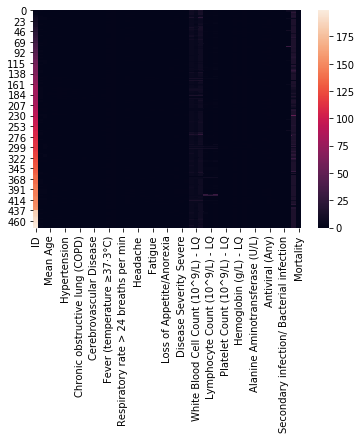

In [19]:
sns.heatmap(df_train)

#### Splitting the dataset

In [20]:
x=df_train.drop('Mortality',axis=1)
y=df_train['Mortality']

In [21]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2)

In [22]:
rmse_val = []
for K in range(150):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(xtrain, ytrain)
    pred=model.predict(xtest)
    error = sqrt(mean_squared_error(ytest,pred))
    rmse_val.append(error)
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.2655560204551951
RMSE value for k=  2 is: 0.2755625824420022
RMSE value for k=  3 is: 0.2842184317722275
RMSE value for k=  4 is: 0.27477766131528003
RMSE value for k=  5 is: 0.2736373320175524
RMSE value for k=  6 is: 0.2784268673598801
RMSE value for k=  7 is: 0.2851728328149879
RMSE value for k=  8 is: 0.2803394910874276
RMSE value for k=  9 is: 0.2737255067059745
RMSE value for k=  10 is: 0.2740724452825528
RMSE value for k=  11 is: 0.27375363491939053
RMSE value for k=  12 is: 0.2787511309079412
RMSE value for k=  13 is: 0.2852100254937886
RMSE value for k=  14 is: 0.28780579403576734
RMSE value for k=  15 is: 0.29195701037384386
RMSE value for k=  16 is: 0.2919669499027695
RMSE value for k=  17 is: 0.2958577441464803
RMSE value for k=  18 is: 0.2979300365734505
RMSE value for k=  19 is: 0.30045093678951873
RMSE value for k=  20 is: 0.30335439583708723
RMSE value for k=  21 is: 0.30328543509018796
RMSE value for k=  22 is: 0.30856009514906385
RMSE value 

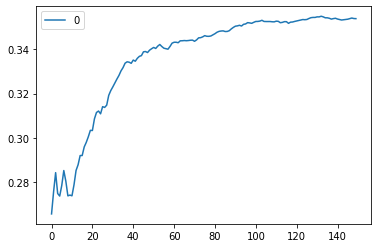

In [23]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

#### Calculating cross value method to find the best bit model

#### ElasticNet

In [24]:
from sklearn.linear_model import ElasticNet
#ElasticNet = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [25]:
cross_val_score(ElasticNet(alpha=1.0, l1_ratio=0.5), xtrain, ytrain,cv=3)

array([-0.00145628, -0.01778179, -0.00809296])

#### Ridge

In [26]:
from sklearn.linear_model import Ridge
cross_val_score(Ridge(alpha=0.01), xtrain, ytrain,cv=3)

array([ 0.18309022, -0.16450051,  0.34807879])

#### Lasso

In [27]:
from sklearn.linear_model import Lasso
lasso001 = Lasso(alpha=0.01, max_iter=10e5)

In [28]:
cross_val_score(Lasso(alpha=0.01, max_iter=10e5), xtrain, ytrain,cv=3)

array([0.30847588, 0.28430206, 0.38287071])

#### Trying Artificial Neural Network

In [29]:
ann = keras.Sequential([
    keras.layers.Dense(54, input_shape=(54,),activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(22,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1,activation='sigmoid')
])

ann.compile(optimizer='adam',
           loss='binary_crossentropy',
           metrics=['accuracy'])

ann.fit(xtrain, ytrain,epochs=100)

Epoch 1/100
12/12 [==============================] - 1s 844us/step - loss: 10.0036 - accuracy: 0.2085
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 3.5286 - accuracy: 0.4466
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 2.7048 - accuracy: 0.5754
Epoch 4/100
12/12 [==============================] - 0s 994us/step - loss: 3.1479 - accuracy: 0.4542
Epoch 5/100
12/12 [==============================] - 0s 1ms/step - loss: 2.6056 - accuracy: 0.4807
Epoch 6/100
12/12 [==============================] - 0s 880us/step - loss: 2.0824 - accuracy: 0.4330
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 2.3917 - accuracy: 0.4242
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 2.0903 - accuracy: 0.3992
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4423 - accuracy: 0.4719
Epoch 10/100
12/12 [==============================] - 0s 256us/step - loss: 1.3733 - accuracy: 0.4356


12/12 [==============================] - 0s 3ms/step - loss: 0.3852 - accuracy: 0.5649
Epoch 83/100
12/12 [==============================] - 0s 1ms/step - loss: 0.4503 - accuracy: 0.5201
Epoch 84/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4106 - accuracy: 0.5433
Epoch 85/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.5347
Epoch 86/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4030 - accuracy: 0.5671
Epoch 87/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4585 - accuracy: 0.5042
Epoch 88/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4224 - accuracy: 0.5232
Epoch 89/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4044 - accuracy: 0.5486
Epoch 90/100
12/12 [==============================] - 0s 2ms/step - loss: 0.4037 - accuracy: 0.5537
Epoch 91/100
12/12 [==============================] - 0s 1ms/step - loss: 0.3710 - accuracy: 0.5701
Epoch 92/100


In [30]:
y_pred_nn = ann.predict(df_valid)
y_pred_nn = y_pred_nn.flatten()

testData = pd.read_excel('test_data.xlsx')
ANN_Submission = pd.DataFrame({
        "ID": testData['ID'],
        "Mortality": y_pred_nn
    })

In [31]:
#ANN_Submission.to_csv('MortalityRate2.csv',index=False)

#### KNN algorithm looks fine comparing to other algorithms for this model

In [32]:
rmse_val = []
for K in range(50):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(xtrain, ytrain)
    pred=model.predict(xtest) 
    error = sqrt(mean_squared_error(ytest,pred))
    rmse_val.append(error)
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.2655560204551951
RMSE value for k=  2 is: 0.2755625824420022
RMSE value for k=  3 is: 0.2842184317722275
RMSE value for k=  4 is: 0.27477766131528003
RMSE value for k=  5 is: 0.2736373320175524
RMSE value for k=  6 is: 0.2784268673598801
RMSE value for k=  7 is: 0.2851728328149879
RMSE value for k=  8 is: 0.2803394910874276
RMSE value for k=  9 is: 0.2737255067059745
RMSE value for k=  10 is: 0.2740724452825528
RMSE value for k=  11 is: 0.27375363491939053
RMSE value for k=  12 is: 0.2787511309079412
RMSE value for k=  13 is: 0.2852100254937886
RMSE value for k=  14 is: 0.28780579403576734
RMSE value for k=  15 is: 0.29195701037384386
RMSE value for k=  16 is: 0.2919669499027695
RMSE value for k=  17 is: 0.2958577441464803
RMSE value for k=  18 is: 0.2979300365734505
RMSE value for k=  19 is: 0.30045093678951873
RMSE value for k=  20 is: 0.30335439583708723
RMSE value for k=  21 is: 0.30328543509018796
RMSE value for k=  22 is: 0.30856009514906385
RMSE value 

In [33]:
pred = model.predict(df_valid)
pred = np.round(pred, decimals=2)
pred_knn = pd.DataFrame({
        "ID": testData['ID'],
        "Mortality": pred
    })
pred_knn.to_csv('MortalityRate_submit_11032021.csv',index=False)

### Thank you!!!

###### *** End of the document